In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
import re
# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_recall_fscore_support,precision_score,recall_score,f1_score
import random
from sklearn.metrics import confusion_matrix


pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

plt.style.use('ggplot')

def randomised_search_cv(classifier,parameters,df,col_list,labels,num_iter=500):
    accuracy_list = []
    RSEED = 42
    for i in range(num_iter):
        
        if i%(num_iter/4)==0:
            print(str(i)+"iterations ran")

        param_iter = {}
        for key,value in parameters.items():
            param_iter[key] = random.choice(value)
        clf = classifier(random_state=RSEED, **param_iter)

        scores = cross_val_score(clf, df[col_list], labels, cv=5,scoring="f1")
        accuracy_list += [(param_iter, np.mean(scores))]

    accuracy_list.sort(key = lambda x: x[1])
    print(accuracy_list[-1])
    return accuracy_list[-1]

def generate_prc(y_true, y_proba):
    return precision_recall_curve(y_true, y_proba[:, 1])

def plot_curves(clf_curves, ctype='roc', legend=False):
    clfs = clf_curves.keys()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    for clf, curve in clf_curves.items():
        if ctype == 'roc':
            x = curve[0]
            y = curve[1]
            xlabel = 'False Positive Rate'
            ylabel = 'True Positive Rate'
            ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
        if ctype == 'prc':
            x = curve[1]
            y = curve[0]
            xlabel = 'Recall'
            ylabel = 'Precision'
        if 'all' in clf:
            ax.plot(x, y, lw=3, color='k', label='%s AUC: %.4f' % (clf, auc(x, y)))
        else:
            ax.plot(x, y, lw=2, alpha=0.5, label='%s AUC: %.4f' % (clf, auc(x, y)))
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if legend:
        ax.legend(loc='best', fontsize=10)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_yticks(np.linspace(0, 1, 11))
    
    
def modelbuilder(classifier,parameters,train_data,test_data,col_list,train_labels,test_labels,title):
    clf = classifier(**parameters)
    trained_model = clf.fit(train_data[col_list], train_labels)
    print("Precision on train",precision_score(train_labels,clf.predict(train_data[col_list])) )
    print("Recall on train",recall_score(train_labels,clf.predict(train_data[col_list])) )
    print("F1 score on train",f1_score(train_labels,clf.predict(train_data[col_list])) )
#     params = {"verbose":0}
    
#     trained_model.set_params(**parameters)
    y_pred = clf.predict_proba(test_data[col_list])
    inc_prc = generate_prc(test_labels, y_pred)
    plot_curves({title: inc_prc}, ctype='prc', legend=True)
    y_predicted = clf.predict(test_data[col_list])
    prec_score= precision_score(test_labels,y_predicted)
    rec_score= recall_score(test_labels,y_predicted)
    f1 = 2*(prec_score*rec_score)/(prec_score+rec_score)
    print("Precision on test:",prec_score)
    print("Recall on test:",rec_score)
    print("F1 Score on test: ",f1)
    print(confusion_matrix(test_labels, y_predicted))
#     holdout_df = holdout_df.copy()
#     holdout_df['is_promoted'] = clf.predict(holdout_df[col_list])
#     holdout_df[['employee_id','is_promoted']].to_csv("../submissions/"+title+".csv",index=False)

In [4]:
train = pd.read_csv("../datasets/train.csv")
test = pd.read_csv("../datasets/test.csv")
game_overview = pd.read_csv("../datasets/game_overview.csv")

In [5]:
for i in [train,test,game_overview]:
    print(i.shape)
    print(i.columns)
    print(i.isnull().sum())
    print("\n")
    

(17494, 5)
Index(['review_id', 'title', 'year', 'user_review', 'user_suggestion'], dtype='object')
review_id            0
title                0
year               178
user_review          0
user_suggestion      0
dtype: int64


(8045, 4)
Index(['review_id', 'title', 'year', 'user_review'], dtype='object')
review_id       0
title           0
year           67
user_review     0
dtype: int64


(64, 5)
Index(['title', 'developer', 'publisher', 'tags', 'overview'], dtype='object')
title        0
developer    0
publisher    0
tags         0
overview     0
dtype: int64




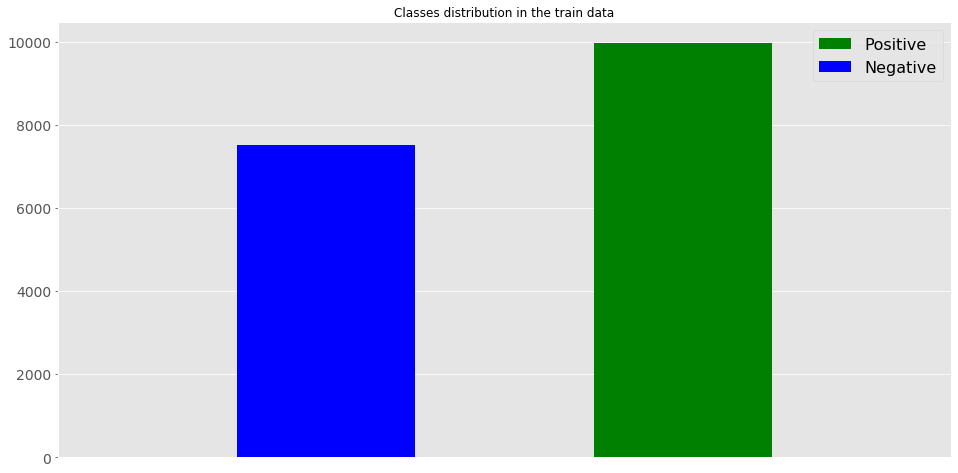

In [6]:
plt.hist(train[train.user_suggestion == 1].user_suggestion,
         bins=2, color='green', label='Positive')
plt.hist(train[train.user_suggestion == 0].user_suggestion,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=SMALL_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [7]:
full_train = pd.merge(train,game_overview,on='title',how='left')
full_test = pd.merge(test,game_overview,on='title',how='left')

In [8]:
full_train.columns

Index(['review_id', 'title', 'year', 'user_review', 'user_suggestion',
       'developer', 'publisher', 'tags', 'overview'],
      dtype='object')

In [9]:
train_without_labels = full_train[['year','developer', 'publisher', 'tags', 'overview']]
test_without_labels = full_test[['year','developer', 'publisher', 'tags', 'overview']]
train_labels = train['user_suggestion']
del full_train,full_test

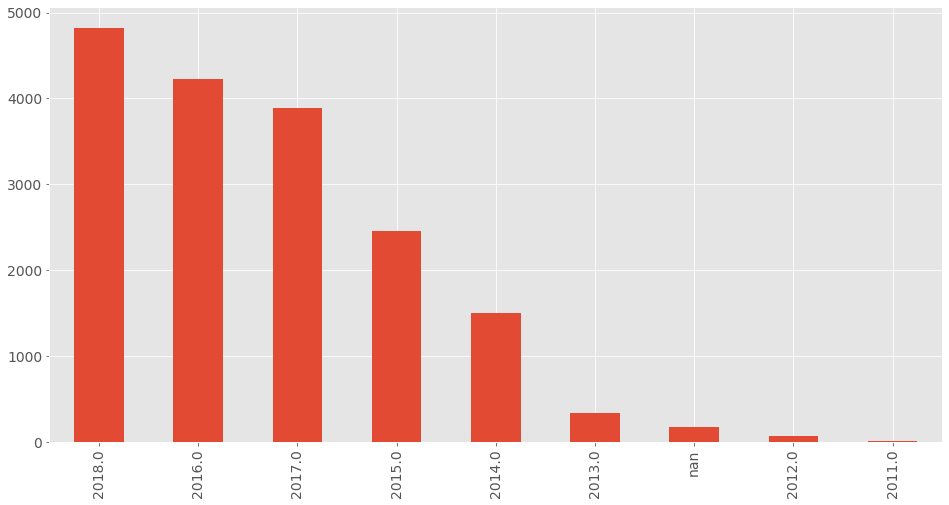

In [10]:
pd.Series(list(train['year'].value_counts(dropna=False)), index=list(train['year'].value_counts(dropna=False).index)).plot(kind='bar')

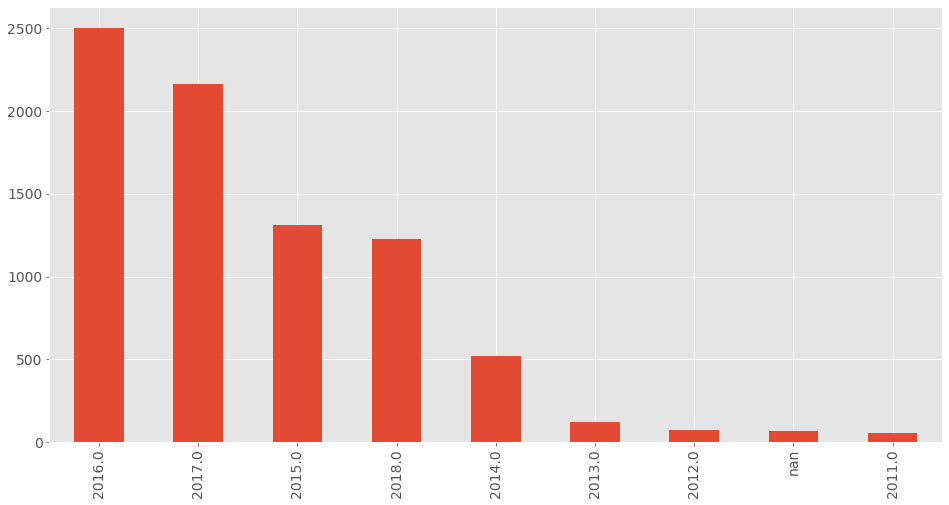

In [11]:
pd.Series(list(test['year'].value_counts(dropna=False)), index=list(test['year'].value_counts(dropna=False).index)).plot(kind='bar')

In [12]:
print("Mean,Median for columns year in training dataset -> ",train['year'].mean(),train['year'].median())
print("Mean,Median for columns year in test dataset -> ",test['year'].mean(),test['year'].median())

Mean,Median for columns year in training dataset ->  2016.388426888427 2017.0
Mean,Median for columns year in test dataset ->  2016.166207069441 2016.0


In [13]:
train.groupby('year').agg({'user_suggestion':'mean'}).reset_index().rename(columns={'user_suggestion':'event_rate'})

,year,event_rate
0,2011.0,0.928571
1,2012.0,0.969231
2,2013.0,0.805882
3,2014.0,0.621081
4,2015.0,0.706504
5,2016.0,0.506389
6,2017.0,0.593059
7,2018.0,0.502074


In [14]:
full_without_labels = pd.concat([train_without_labels,test_without_labels])

In [15]:
full_without_labels['year'] = full_without_labels.year.fillna(2016)

In [16]:
###['year','developer', 'publisher', 'tags', 'overview']

In [17]:
for col in ['developer','tags','overview']:
    full_without_labels[col] = full_without_labels[col].str.strip().str.lower()
full_without_labels_dummy = pd.get_dummies(full_without_labels,columns=['publisher','developer'])

In [18]:
publisher_columns = [x for x in full_without_labels_dummy.columns if x.startswith('publisher')]
developer_columns = [x for x in full_without_labels_dummy.columns if x.startswith('developer')]
len(publisher_columns),len(developer_columns)

(54, 59)

In [19]:
full_without_labels["tags2"] = list(map(lambda x: re.sub("'","",x[1:-1].strip().lower()).split(",") , full_without_labels["tags"]))

tag_list = []
for i in range(len(full_without_labels)):
    tag_list += full_without_labels['tags2'].iloc[i]
    
tag_list = list(set([x.strip() for x in tag_list]))
print(len(tag_list))

161


In [20]:
for item in tag_list:
    full_without_labels["tag|||"+item]= list(map(lambda x: 1 if item in x.lower() else 0, full_without_labels['tags']))

In [21]:
def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters


def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

In [22]:
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

In [23]:
full_without_labels['overview2'] = list(map(lambda x: REPLACE_WITH_SPACE.sub(" ",x), full_without_labels['overview']))

In [24]:
word_vect1 = TfidfVectorizer(strip_accents ='unicode', 
                            min_df=5,max_df=0.9999,
                            stop_words='english', 
                            analyzer='word', 
                            ngram_range = (1,4), 
                            sublinear_tf = True)

In [25]:
word_vect1.fit(full_without_labels['overview2'])
all_overview_tfidf = word_vect1.transform(full_without_labels['overview2'])

In [26]:
feature_names1 = np.array(word_vect1.get_feature_names())
print(len(word_vect1.get_feature_names()))
print('Some elements of feature names in word vectorizer are:\n{}\n'.format(feature_names1[::20]))

34077
Some elements of feature names in word vectorizer are:
['abilities' 'abilities customize appearance' 'abilities make mark' ...
 'yasuda mizuho' 'yggdrasil controlled managed' 'yugi kaiba joey mai']



In [27]:
sorted_tfidf_index = all_overview_tfidf.max(0).toarray()[0].argsort()
print('Words with smallest tfidf:\n{}\n'.format(feature_names1[sorted_tfidf_index[:20]]))
print('Words with largest tfidf: \n{}'.format(feature_names1[sorted_tfidf_index[:-20:-1]]))

Words with smallest tfidf:
['thing' 'rapid' 'examples' 'engaging' 'flow' 'guns world' 'dream'
 'models unlocked' 'models spending dime' 'models unlocked free'
 'arisakaosv karabiner' 'modelsbikecaptain'
 'arisakaosv karabiner machine gunm' 'arisakaosv karabiner machine'
 'models spending' 'models spending dime available'
 'models unlocked free power' 'learning aid armorers law'
 'models pistolsglock cz colt' 'modelsbikecaptain americaducati']

Words with largest tfidf: 
['smite' 'cs' 'apocalypse' 'paladins' 'poker' 'basketball' 'wait'
 'deck scratch' 'scratch battle' 'draft deck scratch battle'
 'deck scratch battle' 'draft deck scratch' 'draft deck' 'vault'
 'business' 'dota' 'bloons' 'dragon' 'digimons']


In [30]:
dev_tag_pub_data = pd.merge(full_without_labels[["tag|||"+x for x in tag_list]], full_without_labels_dummy[developer_columns+publisher_columns+['year']],left_index=True,right_index=True,how="left")